In [55]:
import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [56]:
%matplotlib inline

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
plt.style.use(["science", "ieee", "grid", "no-latex"])

In [59]:
# Constants
OUTPUT_DIR = Path("results") / "experiments"
OUTPUT_CSV = OUTPUT_DIR / "experiments_results.csv"
IGNORE_CSV = True

In [60]:
# Column configurations for guild compare command
METADATA_COLUMNS = [
    "run",
    "max accuracy",
    "=data.init_args.sampling_weights.diff as diff",
    "=data.init_args.sampling_weights.fam as fam",
    "=data.init_args.sampling_weights.ind as ind",
    "=data.init_args.sampling_weights.rel as rel",
    "=model.init_args.loss.init_args.alpha_neg as alpha_neg",
    "=model.init_args.loss.init_args.tau as tau",
    "=model.init_args.enable_hcl_on as enable_hcl",
]

# Column names after extraction (without the guild syntax)
COLUMNS = [
    "run",
    "accuracy",
    "diff",
    "fam",
    "ind",
    "rel",
    "alpha_neg",
    "tau",
    "enable_hcl",
]

In [61]:
def generate_guild_metadata() -> pd.DataFrame:
    """Generate metadata CSV using Guild AI command and return as DataFrame."""
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    metadata_csv = OUTPUT_DIR / "guild_metadata.csv"

    # Check if metadata file exists
    if metadata_csv.exists() and not IGNORE_CSV:
        print("Reading existing metadata file...")
        df = pd.read_csv(metadata_csv)
    else:
        print("Generating new metadata file...")
        guild_command = [
            "guild",
            "compare",
            "-Fo",
            "scl:train",
            "6:195",
            "-cc",
            ",".join(METADATA_COLUMNS),
            "--csv",
            str(metadata_csv),
        ]

        try:
            subprocess.run(guild_command, check=True)
            df = pd.read_csv(metadata_csv)
        except subprocess.CalledProcessError as e:
            raise RuntimeError(f"Failed to execute Guild command: {e}")
        except Exception as e:
            raise RuntimeError(f"Failed to process Guild metadata: {e}")

    # Fill NaN values with 0 for hyperparameters
    df = df.fillna(
        {
            "diff": 0,
            "fam": 0,
            "ind": 0,
            "rel": 0,
            "alpha_neg": 0,
            "tau": 0,
            "enable_hcl": 0,
        }
    )

    # Filter experiments based on requirements
    valid_values = [0, 0.25, 1.0]
    df = df[
        (df["diff"].isin(valid_values))
        & (df["fam"].isin(valid_values))
        & (df["ind"].isin(valid_values))
        & (df["rel"].isin(valid_values))
        & (df["enable_hcl"] != 5)
    ]

    return df

In [62]:
def plot_accuracy_vs_hparams(df: pd.DataFrame):
    """Create scatter plots of accuracy vs each hyperparameter."""
    sampling_hparams = ["diff", "fam", "ind", "rel"]
    loss_hparams = ["alpha_neg", "tau", "enable_hcl"]

    # Plot sampling optimization
    fig1, axes1 = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
    plot_group(df, sampling_hparams, axes1, "Sampling Optimization")
    plt.savefig(OUTPUT_DIR / "accuracy_vs_sampling.png", bbox_inches="tight", dpi=300)
    plt.show()

    # Plot loss optimization
    fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    plot_group(df, loss_hparams, axes2, "Loss Optimization")
    plt.savefig(OUTPUT_DIR / "accuracy_vs_loss.png", bbox_inches="tight", dpi=300)
    plt.show()


def plot_group(df, hparams, axes, title):
    """Helper function to plot a group of hyperparameters."""
    # Get top 5 experiments
    top_5_df = df.nlargest(5, "accuracy")

    # Define markers and colors for top 5
    markers = ["*", "^", "s", "D", "v"]
    colors = ["red", "green", "orange", "purple", "cyan"]

    # Create subplots for each hyperparameter
    for i, hparam in enumerate(hparams):
        ax = axes[i]

        # Plot all points in gray
        ax.scatter(
            df[hparam], df["accuracy"], color="gray", alpha=0.3, marker="o", s=50
        )

        # Plot top 5 with different markers and colors
        for idx, (_, row) in enumerate(top_5_df.iterrows()):
            ax.scatter(
                row[hparam],
                row["accuracy"],
                color=colors[idx],
                marker=markers[idx],
                s=60,
            )

        # Set labels without greek letters
        hparam_label = {
            "alpha_neg": "alpha neg",
            "tau": "tau",
            "enable_hcl": "enable hcl",
        }.get(hparam, hparam)

        ax.set_title(f"Accuracy vs {hparam_label}")
        ax.set_xlabel(f"{hparam_label}")
        if i == 0:  # Only set ylabel for first subplot
            ax.set_ylabel("Accuracy")

    plt.suptitle(title)
    plt.tight_layout()


def format_latex_table(df):
    """Format top 5 results as a LaTeX table."""
    latex_str = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{cccccccc}\n"
    latex_str += "\\toprule\n"
    latex_str += "Acc. & d & f & i & r & $\\alpha$ & $\\tau$ & hcl \\\\\n"
    latex_str += "\\midrule\n"

    for _, row in df.iterrows():
        latex_str += f"{row['accuracy']:.3f} & "
        latex_str += f"{row['diff']:.2f} & "
        latex_str += f"{row['fam']:.2f} & "
        latex_str += f"{row['ind']:.2f} & "
        latex_str += f"{row['rel']:.2f} & "
        latex_str += f"{row['alpha_neg']:.2f} & "
        latex_str += f"{row['tau']:.2f} & "
        latex_str += f"{int(row['enable_hcl'])} \\\\\n"

    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}\n"
    latex_str += "\\caption{Top 5 experiments by accuracy}\n"
    latex_str += "\\label{tab:top5}\n"
    latex_str += "\\end{table}"

    return latex_str

In [63]:
def main():
    """Main execution function."""
    # Get metadata from Guild
    df = generate_guild_metadata()

    # Save raw data
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Raw data saved to {OUTPUT_CSV}")

    # Create plots
    plot_accuracy_vs_hparams(df)
    print(f"Plots saved to {OUTPUT_DIR}/accuracy_vs_sampling.png")
    print(f"Plots saved to {OUTPUT_DIR}/accuracy_vs_loss.png")

    # Print summary statistics
    print("\nSummary Statistics:")
    print(df.describe())

    # Print top 5 experiments by accuracy
    print("\nTop 5 experiments by accuracy:")
    print(df.nlargest(5, "accuracy")[COLUMNS])  # Use clean column names

    # Print LaTeX table
    print("\nLaTeX table format:")
    print(format_latex_table(df.nlargest(5, "accuracy")))

Generating new metadata file...


Wrote 190 row(s) to results/experiments/guild_metadata.csv


Raw data saved to results/experiments/experiments_results.csv


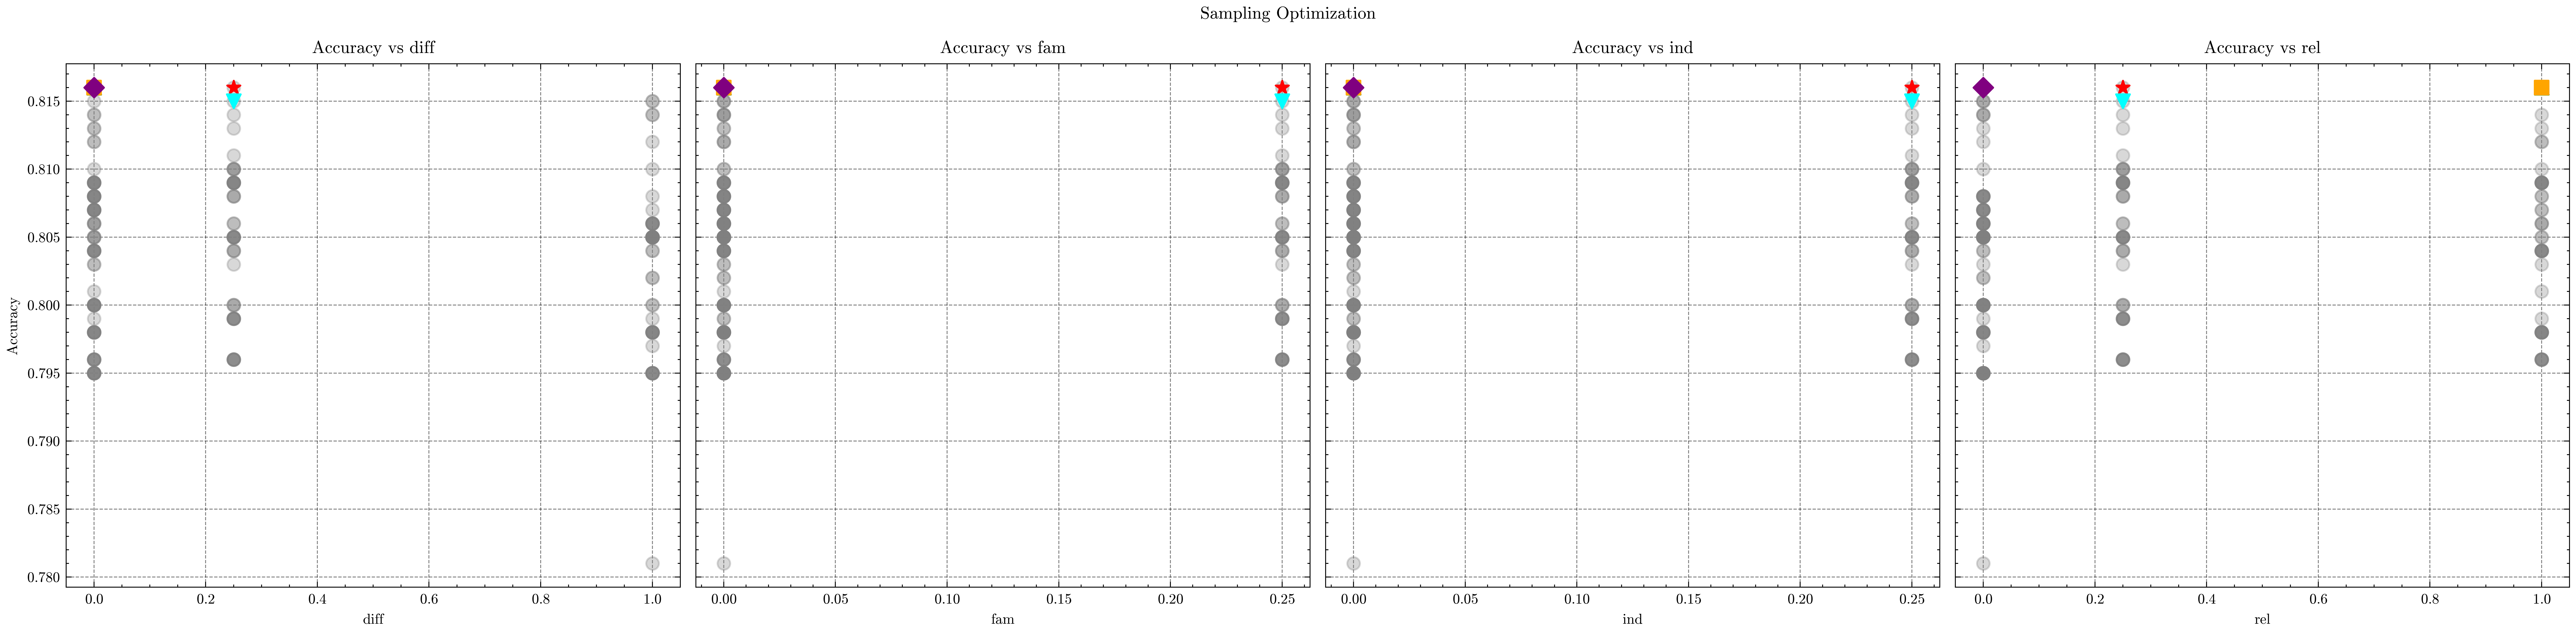

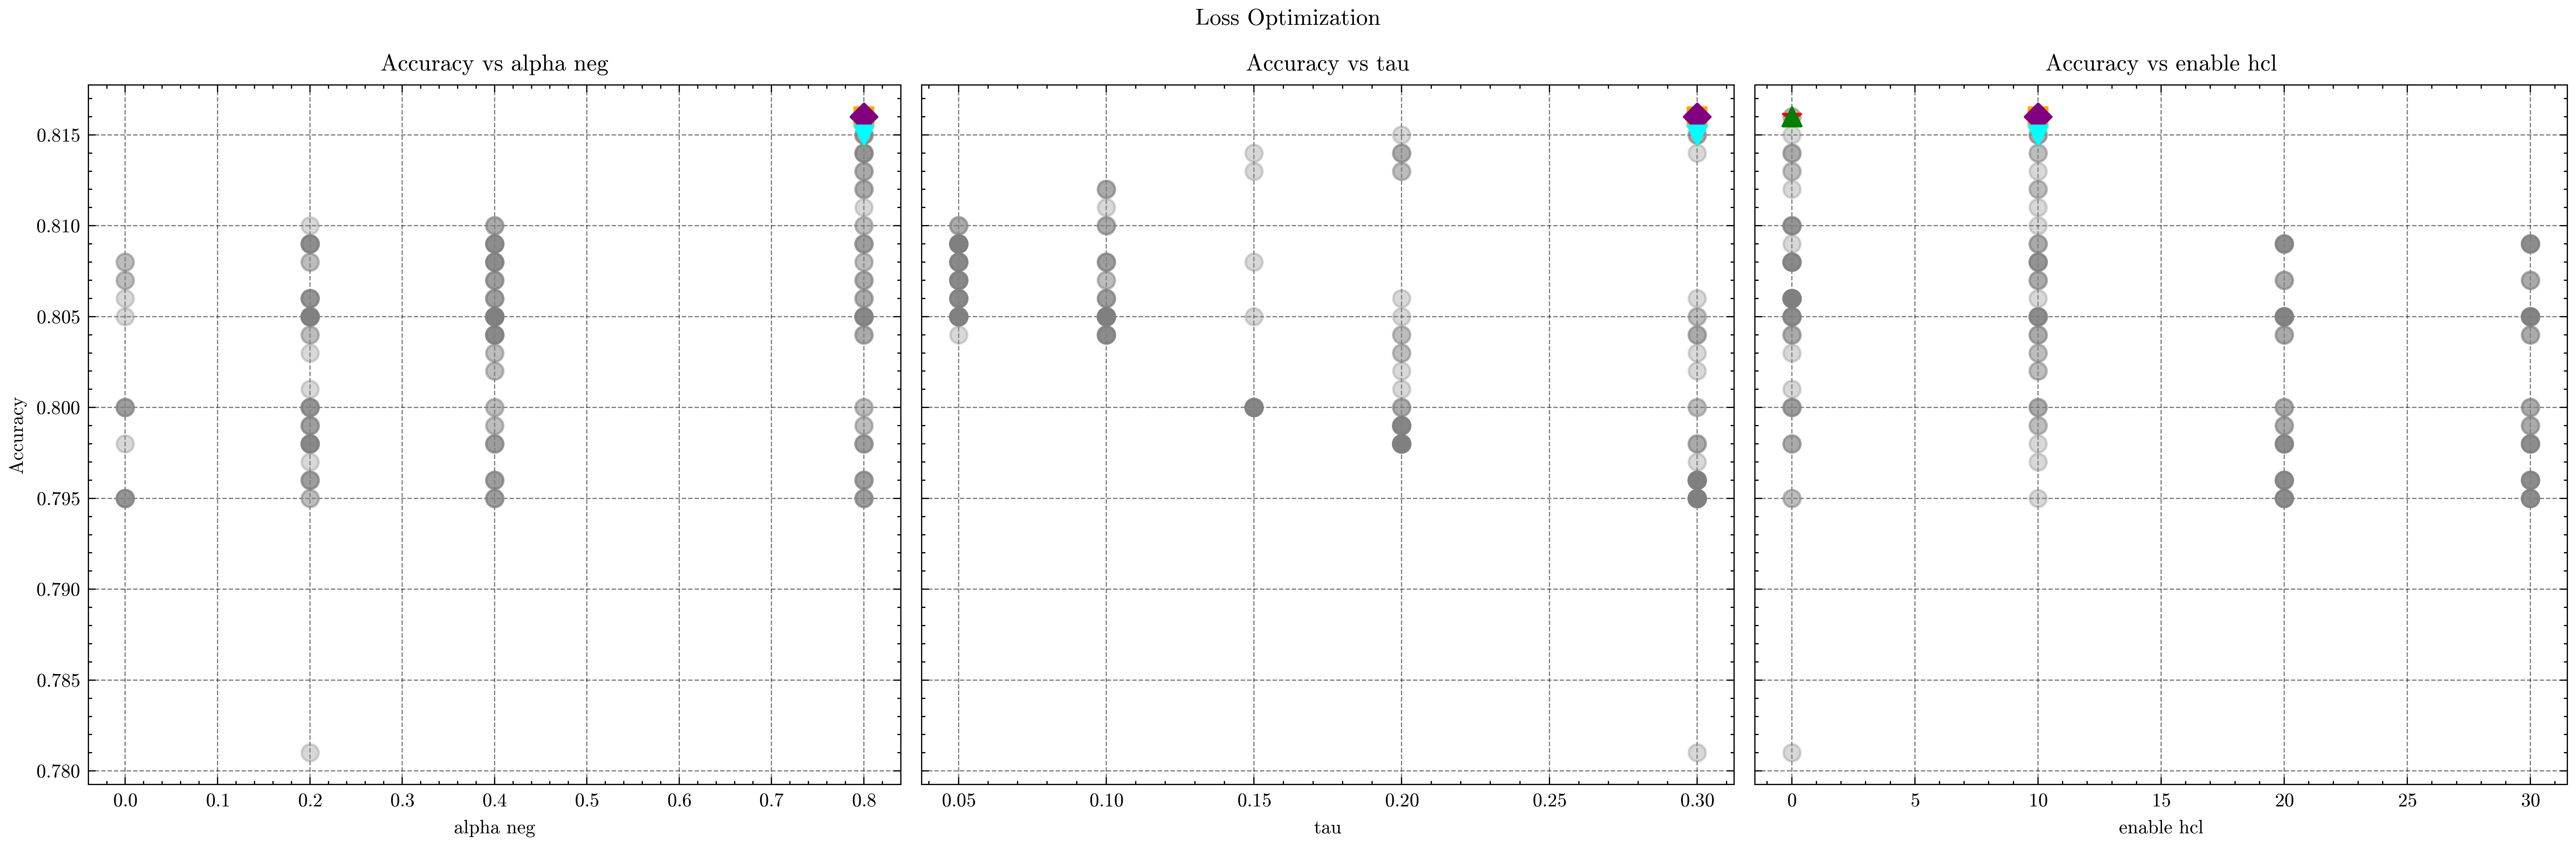

Plots saved to results/experiments/accuracy_vs_sampling.png
Plots saved to results/experiments/accuracy_vs_loss.png

Summary Statistics:
         accuracy        diff         fam         ind         rel   alpha_neg  \
count  190.000000  190.000000  190.000000  190.000000  190.000000  190.000000   
mean     0.803937    0.368421    0.063158    0.063158    0.315789    0.436842   
std      0.005900    0.431624    0.108917    0.108917    0.411814    0.272380   
min      0.781000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.799000    0.000000    0.000000    0.000000    0.000000    0.200000   
50%      0.805000    0.250000    0.000000    0.000000    0.250000    0.400000   
75%      0.808000    1.000000    0.187500    0.187500    0.812500    0.800000   
max      0.816000    1.000000    0.250000    0.250000    1.000000    0.800000   

              tau  enable_hcl  
count  190.000000  190.000000  
mean     0.162105   14.210526  
std      0.097784   11.416033  
min  

In [64]:
main()